# Basic preparations

In this Notebook, the geospatial fabric for the "Bow River at Calgary" gauge is extracted from the `MERIT-Basins` dataset.

Access to raw `MERIT-Basins` dataset is needed. On DRAC Fir HPC, it is located in the following path:

```console
/project/rrg-alpie/data/misc-data/MERIT-Basins
```

The version used is `MERIT_Hydro_v07_Basins_v01_bugfix1` which is a directory under the root directory of the dataset.

Let's get started with our workflow and import necessary Python libraries:

In [1]:
# import geopandas as gpd # version 0.14.0
import pandas as pd # version 1.4.0
import numpy as np # version 1.22.2
import matplotlib.pyplot as plt # version 3.5.1
import geopandas as gpd # version 0.14.3

from shapely.geometry import Point # version 2.0.1

import hydrant.topology.geom as gm # version 0.1.0-dev1

import subprocess # built-in Python 3.10.2
import os # built-in Python 3.10.2
import glob # built-in Python 3.10.2

`Hydrant` is important in this Notebook. We are only using the `topology.geom`etry module.

Path definitions (system dependant - modify accordingly):

In [2]:
# geofabric paths
## merit-basins provided in `rrg-mclark` - modify as needed
merit_basins_root_path = '/project/rrg-alpie/data/misc-data/MERIT-Basins/MERIT_Hydro_v07_Basins_v01_bugfix1'
merit_basins_geom_path = os.path.join(merit_basins_root_path, 'pfaf_level_02')
merit_basins_nca_path = os.path.join(merit_basins_root_path, 'coastal_hillslopes')

# output paths
output_path = './bow-at-calgary-geofabric/'

# Reading `MERIT-Basins` Geospatial Fabric Dataset

## `MERIT-Basins` Geospatial Layers

Upon **visual** inspection (you may use `QGIS` or similar programs), layer #71 has been identified to include necessary sub-basins and river segments for the Bow River at Calgary watershed:

As you may see in the cell below, we are using Python `list`s to enable reading multiple layers at once. There are cases where a basin of interest is shared between multiple `pfaf` layers.

For now, let's read the files, one by one:

In [3]:
# file names
# catchments (subbasin)
cat_files = [
    'cat_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# rivers (river segments)
riv_files = [
    'riv_pfaf_71_MERIT_Hydro_v07_Basins_v01_bugfix1.shp',
]
# non-contributing catchments (those without any river segments defined for them)
nca_files = [
    'hillslope_71_clean.shp',
]

# reading in data in an iterative manner
cat = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(merit_basins_geom_path, f)) for f in riv_files])
nca = pd.concat([gpd.read_file(os.path.join(merit_basins_nca_path, f)) for f in nca_files])

Since `MERIT-Basins` layers do not come with correct Coordinate Reference System (CRS) information, we need to specify this manually. The `EPSG` code for the `MERIT-Basins` layer is `4326`. Please refer to the following for more information: https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset

In [4]:
# specifying epsg:4326 for all the MERIT-Basins layers
cat.set_crs(epsg=4326, inplace=True)
nca.set_crs(epsg=4326, inplace=True)
riv.set_crs(epsg=4326, inplace=True)

# Show the EPSG of all geospatial layers
print(f'`cat` CRS: {cat.crs}')
print(f'`riv` CRS: {riv.crs}')
print(f'`nca` CRS: {nca.crs}')

`cat` CRS: EPSG:4326
`riv` CRS: EPSG:4326
`nca` CRS: EPSG:4326


## Bow River At Calgary Hydrometric Gauge Location

Based on the information provided by the Water Survery of Canada (WSC), the latitude and longitude of this hydrometric gauge is as follows:

* Latitude:   `51.051`
* Longitude: `-114.089`

Based on the information above, we use `hydrant` to extract all the river segment of sub-basins upstream of the coordinates above.

# Preparing `cat`, `riv`, and `nca` objects for `Bow River at Calgary`

## Preparing `MERIT-Basins` Layers

Before subsetting the entire layer #71 of the `MERIT-Basins` dataset, we have to assure the layers are ready to be further processed by the `Hydrant` package. Fortunately, `Hydrant` provides necessary functionalities to work with this specific geospatial fabric (applicable to any geospatial fabric in reality). 

In doing so, Hydrant's `geom` module provides the `prepare_cat(...)` function to prepare the `MERIT-Basins` geosptial fabric's sub-basins (or catchments) for the next post-processing steps. Please note that since the non-contributing areas (`nca`) are technically considered sub-basins, they are taken care of using this functionality of `Hydrant`:

In [5]:
# Hydrant's `geom` module provides the `prepare_cat`
# function to prepare the `MERIT-Basins` geosptial
# fabric for next post-processing steps

catchments = gm.prepare_cat(
    cat=cat, # 
    cat_col_id='COMID',
    cst=nca,
    cst_col_mapper={'FID':'COMID'},
    cst_col_id='COMID'
)

# You may see the "docstring" of the `gm.prepare_cat`
# function by running:
# >>> gm.prepare_cat?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_cat.__doc__)

Similarly, the `geom` module provides the `prepare_riv(...)` function to prepare the `MERIT-Basins` geospatial fabric's river segments for the next post-processing steps:

In [6]:
# Similarly, the `geom` module provides the
# `prepare_riv` function to prepare the `MERIT-Basins`
# geospatial fabric's river segments for the next
# post-processing steps:

rivers = gm.prepare_riv(
    riv=riv,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID',
        'slope':'slope',
        'length':'lengthkm',
        'length_direct':'lengthdir'
    },
    cat=catchments,
    cat_cols={
        'id':'COMID',
        'hillslope':'hillslope',
        'geom':'geometry'
    }
)

# You may see the "docstring" of the `gm.prepare_riv`
# function by running:
# >>> gm.prepare_riv?
# in a separate Jupyter cell (without the >>>), or by
# running simply:
# >>> print(gm.prepare_riv.__doc__)

/home/kasra545/virtual-envs/scienv2/lib/python3.11/site-packages/hydrant/topology/geom.py:254: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1e-08' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  river.loc[river[hillslope_id] == 1, col_list] = riv_na_val


In Python, you may always access the "docstring" documentations for the functions and classes by running:

```python
>>> print(func.__doc__)
```

Or, if you are working in the Jupyter environment, you may simply run the following in a separate Jupyter cell:
```ipython
[ln1] func?
```

If you are interested in reading up on the functionality of each function used above, use the mentioned methods to print the "docstrings".

Therefore, if you would like to read up on the `gm.prepare_cat(...)` or `gm.prepare_riv(...)` functionality, simply uncomment and execute the following cell:

In [7]:
gm.prepare_cat?

Signature:
gm.prepare_cat(
    cat: geopandas.geodataframe.GeoDataFrame,
    cat_col_id: str,
    cst: Optional[geopandas.geodataframe.GeoDataFrame] = None,
    cst_col_mapper: Optional[Dict[str, str]] = None,
    cst_col_id: Optional[str] = None,
    cst_colid_reset: bool = True,
    crs: int = 4326,
    *args,
) -> geopandas.geodataframe.GeoDataFrame
Docstring:
Preparing `catchment` object as part of the mizuroute setup workflow

Parameters
----------
cat: str or geopandas.GeoDataFrame
    The address or the geopandas.GeoDataFrame object of the `catchment`
    layer
cat_col_id: str
    The column name of `cat` indicating IDs of available geometries
nca: str or geopandas.GeoDataFrame, optional [defaults to None]
    The address or the geopandas.GeoDataFrame object of the
    non-contributing catchment layer
nca_col_map: dict, optional [defaults to None]
    Dictionary used for renaming necessary columns of `nca`
nca_col_id: str, optional [defaults to None]
    The column name of `nca`

In [8]:
gm.prepare_riv?

Signature:
gm.prepare_riv(
    riv: geopandas.geodataframe.GeoDataFrame,
    riv_cols: Dict[str, str],
    cat: geopandas.geodataframe.GeoDataFrame,
    cat_cols: Dict[str, str],
    outlet_val: int = -9999,
    riv_na_val: int = 1e-08,
    crs: int = 4326,
    *args,
    **kwargs,
) -> geopandas.geodataframe.GeoDataFrame
Docstring:
Preparing the `river` object

Parameters
----------
riv: geopandas.GeoDataFrame
    The river network object containing river segments
riv_cols: dict
    A dictionary containing 'id', 'next_id', keys and values 
    corresponding to the river segement IDs and their downstream
    river segments, respectively. Also, other keys includes 'slope',
    'length', 'length_direct'
cat: geopandas.GeoDataFrame
    The catchment topology object derived from `prepare_cat`
    function
cat_cols: dict
    A dictionary containing 'id', 'hillslope' keys and values
    corresponding to the catchment IDs and also the flag indicating
    whether the catchment is a coastal hil

## Subsetting Sub-basins and River Segments Upstream of the `Bow River at Calgary` Hydrometric Station

First, we need to find the `MERIT-Basins`'s sub-basin where this gauge is located. We use `geopandas` capability to do a quick intersection between the two layers (`MERIT-Basins` sub-basins (Multi-)Polygons and `Bow River at Calgary` gauge Point).

Based on the information provided earlier, the latitude and longitude of this hydrometric gauge is as follows:

* Latitude:   `51.051`
* Longitude: `-114.089`

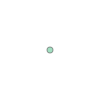

In [9]:
# latitude and longitude values for the
# `Bow River at Calgary`s Hydrometric gauge
latitude = 51.051
longitude = -114.089

# create a Point object
point = Point(longitude, latitude)

# show the `point`
point

In [10]:
print(point)

POINT (-114.089 51.051)


Upon building this layer containing only 1 point, let's find the sub-basin that this gauge intersects with:

In [11]:
catchments[catchments.intersects(point)]

,COMID,unitarea,geometry,hillslope
27941,71027942,153.058954,"POLYGON ((-114.31792 51.18208, -114.31042 51.1...",0


Based on the command above, the sub-basin with `COMID` value of `71027942` intersects with the point coordinates of the Bow River at Calgary hydrometric gauge.

We may proceed by using the `intersect_topology` to extract whatever located upstream of the sub-basin (and river segment) with `COMID` value of `71027942`.

In [12]:
# `bb` stands for `Bow at Calgary`:
bcalgary_catchments, bcalgary_rivers = gm.intersect_topology(
    cat=catchments,
    cat_cols={
        'id':'COMID'
    },
    riv=rivers,
    riv_cols={
        'id':'COMID',
        'next_id':'NextDownID'
    },
    outlet_id=[71027942])

Now, let's plot what have extracted from the larger `MERIT-Basins` geospatial fabric:

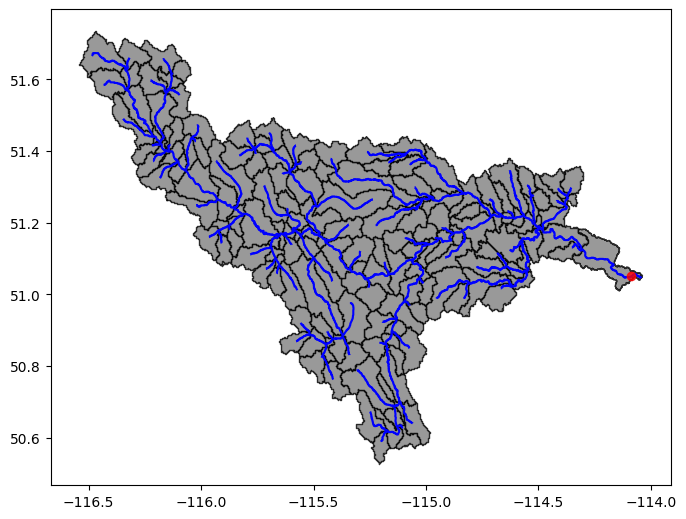

In [13]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 8)
)

# sub-basins
bcalgary_catchments.plot(ax=ax, color='gray', edgecolor='black', alpha=0.8, zorder=1)
# river segments
bcalgary_rivers.plot(ax=ax, color='blue', alpha=1, zorder=2)
# gauge location
ax.scatter(point.x, point.y, color='red', alpha=0.8, zorder=3)

# Saving Extracted Geospatial Fabric upstream of Bow River at Calgary Hydrometric Station

In [14]:
# saving the results into the `output_path` directory

# first, creating the directory
try:
    os.makedirs(output_path)
except FileExistsError:
    pass

# then, saving the data
bcalgary_catchments.to_file(os.path.join(output_path, 'bcalgary_subbasins.shp'))
bcalgary_rivers.to_file(os.path.join(output_path, 'bcalgary_rivers.shp'))

___

# Extract Area Boundary

It is important to understand the overall landcover percentages of various classes, as it informs calibration efforts where land cover classes define vertical computational units of the land/hydrological models.

Before proceeding, we need to dissolve all the sub-basins to achieve the boundary polygon of the area. Thereafter, we use `gistool` again to calculate the percentages:

In [15]:
# dissolving
bcalgary_dissolved = bcalgary_catchments.dissolve()

<Axes: >

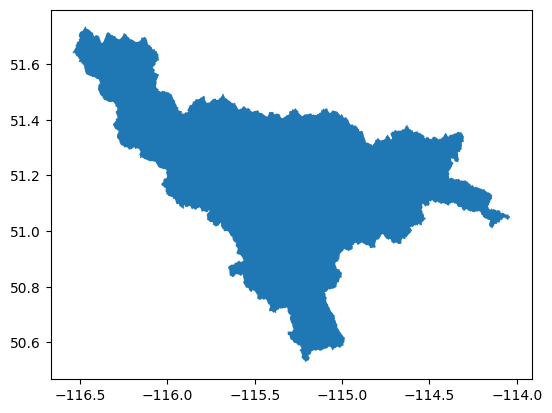

In [16]:
# vizualizing the dissolved catchment
bcalgary_dissolved.plot()

In [17]:
bcalgary_dissolved

,geometry,COMID,unitarea,hillslope
0,"MULTIPOLYGON (((-116.15542 51.26375, -116.1545...",71027942,153.058954,0


In [18]:
# assuring the order of columns make sense
bcalgary_dissolved = bcalgary_dissolved[['COMID', 'unitarea', 'geometry']]

In [19]:
# saving the dissolved catchment polygon
bcalgary_dissolved.to_file(
    filename=os.path.join(
        output_path, 
        'bcalgary-subbasins-dissolved.shp'),
)

If you face any issues, e-mail [kasra.keshavarz1 AT ucalgary DOT ca](mailto:kasra.keshavarz1@ucalgary.ca).